# Example 12 Using Neural Network transfer functions (NNTFs)

In this notebook, we demonstrate how to generate a transfer function from a Neural Network (more specifically, a Multi-layer Perceptron network), compare it against table transfer functions (if available), and use it in `main.evolve` with the `tf_mode` switch.

## Notebook Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..') # append DarkHistory's path

In [32]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc_nntf')
%matplotlib inline

In [3]:
from config import load_data
from nntf.load import load_model

## 1. Generate a NNTF
We use the coarsened high energy photon transfer function `hep_p12` as an example

In [4]:
hep_p12_nntf = load_model('dep_nntf')['hep_p12']

****** Loading (NN) transfer functions... ******
Using data at /zfs/yitians/darkhistory/DHdata_alt/nntf_models
    for propagating photons (compounded)...  Done!
    for propagating photons (propagator)...  Done!
    for low-energy electrons...  Done!
    for low-energy photons...  Done!
****** Loading complete! ******


For some value of redshift $rs$=`rs`, Hydrogen ionization fraction $x_\text{HII}$=`xH`, Helium first ionization fraction $x_\text{HeII}$=`xHe`, let the Neural Network (NN) model predict the transfer function value.

In [10]:
hep_p12_nntf.predict_TF(rs=300, xH=0.6, xHe=0.0)

Now plot the transfer functions.

<ipython-input-11-92715bb2e18d>:7: RuntimeWarning: divide by zero encountered in log10
  negim = ax.imshow(np.flipud(np.log10(-hep_p12_nntf.TF)), vmax=7, vmin=-10, cmap='viridis', extent=extent)
<ipython-input-11-92715bb2e18d>:7: RuntimeWarning: invalid value encountered in log10
  negim = ax.imshow(np.flipud(np.log10(-hep_p12_nntf.TF)), vmax=7, vmin=-10, cmap='viridis', extent=extent)


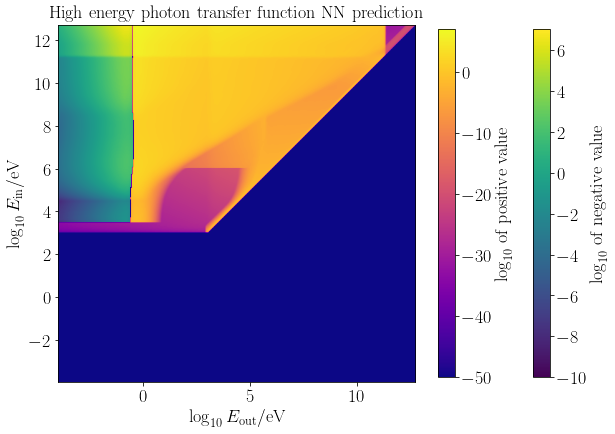

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

extent = np.log10((hep_p12_nntf.abscs[0][0], hep_p12_nntf.abscs[0][-1],
                   hep_p12_nntf.abscs[1][0], hep_p12_nntf.abscs[1][-1]))

posim = ax.imshow(np.flipud(np.log10(np.clip(hep_p12_nntf.TF, 1e-50, 1e50))), vmax=7, vmin=-50, cmap='plasma', extent=extent)
negim = ax.imshow(np.flipud(np.log10(-hep_p12_nntf.TF)), vmax=7, vmin=-10, cmap='viridis', extent=extent)
fig.colorbar(negim, ax=ax, shrink=0.8, label=r'$\log_{10}$ of negative value')
fig.colorbar(posim, ax=ax, shrink=0.8, label=r'$\log_{10}$ of positive value')

ax.set(title='High energy photon transfer function NN prediction',
       xlabel=r'$\log_{10}E_\mathrm{out}/\mathrm{eV}$', ylabel=r'$\log_{10}E_\mathrm{in}/\mathrm{eV}$')
plt.show()

## 2. Comparison with table transfer functions (if tables available)

In [7]:
try:
    hep_tf = load_data('dep_tf')['highengphot']
    tf_E = load_data('tf_helper')['tf_E']
except (FileNotFoundError, ValueError) as err:
    print(type(err).__name__, ':', err)
    print('\nNeed table transfer functions for comparison.')

****** Loading transfer functions... ******
Using data at /zfs/yitians/darkhistory/DHdata_alt
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


Again using high energy photon transfer function as an example.

In [12]:
rs = 300
xH = 0.6
xHe = 0.00

hep_tf_slice = hep_tf.get_tf(xH, xHe, rs)
z_tb = np.linalg.matrix_power(hep_tf_slice.grid_vals, 12)

hep_E = tf_E.get_val(xH, xHe, rs)[0]
hep_p12_nntf.predict_TF(rs=rs, xH=xH, xHe=xHe, E_arr=hep_E)
z_nn = hep_p12_nntf.TF

z_ediff = z_nn-z_tb
absc_in  = load_data('binning')['phot']
absc_out = load_data('binning')['phot']
for ii, Ein in enumerate(absc_in):
    for io, Eout in enumerate(absc_out):
        z_ediff[ii][io] *= (Eout/Ein)

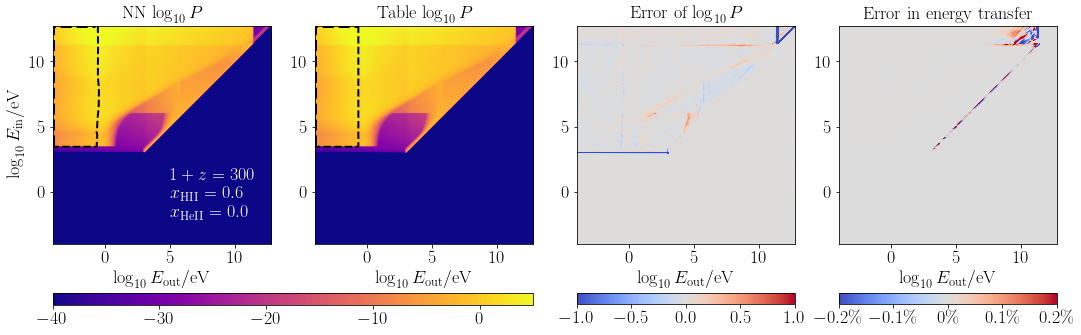

In [15]:
# plot definitions
i_absc, o_absc = hep_p12_nntf.abscs
extent = np.log10((o_absc[0], o_absc[-1], i_absc[0], i_absc[-1]))
xlabel_str = r'$\log_{10}E_\mathrm{out}/\mathrm{eV}$'
ylabel_str = r'$\log_{10}E_\mathrm{in} /\mathrm{eV}$'
EPSILON = 1e-50
plot_val = lambda x: np.flipud(np.log10(np.clip(np.abs(x), EPSILON, None)))
contour_color = 'k'

zc_tb = z_tb.copy()
zc_tb[:,100:] = 1e-50 # set consistent epsilons/zeros

# plot
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

imtf = axs[0].imshow(plot_val(z_nn), vmin=-40, vmax=5, cmap='plasma', extent=extent)
axs[0].contour(z_nn+1e-50, levels=[0], extent=extent, colors=contour_color, linestyles='--', linewidths=2)
axs[0].plot([extent[0]+0.05, extent[0]+0.05, -0.7], [3.5, extent[3]-0.05, extent[3]-0.05], color=contour_color, linestyle='--', linewidth=3)

axs[1].imshow(plot_val(z_tb), vmin=-40, vmax=5, cmap='plasma', extent=extent)
axs[1].contour(zc_tb+1e-50, levels=[0], extent=extent, colors=contour_color, linestyles='--', linewidths=2)
axs[1].plot([extent[0]+0.05, extent[0]+0.05, -0.7], [3.5, extent[3]-0.05, extent[3]-0.05], color=contour_color, linestyle='--', linewidth=3)

imd1 = axs[2].imshow(plot_val(z_nn)-plot_val(z_tb), vmin=-1, vmax=1, cmap='coolwarm', extent=extent)
imd2 = axs[3].imshow(np.flipud(z_ediff), vmin=-0.002, vmax=0.002, cmap='coolwarm', extent=extent)

axs[0].set(title=r'NN $\log_{10}P$', xlabel=xlabel_str, ylabel=ylabel_str)
axs[1].set(title=r'Table $\log_{10}P$', xlabel=xlabel_str)
axs[2].set(title=r'Error of $\log_{10}P$', xlabel=xlabel_str)
axs[3].set(title=r'Error in energy transfer', xlabel=xlabel_str)

fig.colorbar(imtf, ax=axs[:2], orientation='horizontal', aspect=40)
fig.colorbar(imd1, ax=axs[2], orientation='horizontal', aspect=20)
#fig.colorbar(imd2, ax=axs[3], orientation='horizontal', aspect=20)
cbar = fig.colorbar(imd2, ax=axs[3], orientation='horizontal', aspect=20,
                 ticks=[-0.002, -0.001, 0, 0.001, 0.002])
cbar.ax.set_xticklabels([r'$-0.2$\%', r'$-0.1$\%', r'$0$\%', r'$0.1$\%', r'$0.2$\%'])

axs[0].text(5, -2, '$1+z=%d$\n$x_\\mathrm{HII}=%.1f$\n$x_\\mathrm{HeII}=%.1f$' % (rs, xH, xHe), color='white', fontsize=18)

plt.show()

Note that in the area encircled by the black dashed line the transfer function value is negative.

## 3. Using NN option in `main.evolve`

We will be using the same example scenario as in `Example_8_Ionization_and_Thermal_History.ipynb`: a 100 MeV dark matter particle decaying to electron positron pairs with a lifetime of $\tau=3\times10^{25}$ s.

In [17]:
import main

In [19]:
soln = main.evolve(
    DM_process     = 'decay',
    mDM            = 1e8,
    lifetime       = 3e25,
    primary        = 'elec_delta',
    backreaction   = True,
    helium_TLA     = True,
    reion_switch   = True,
    
    start_rs       = 3000,
    end_rs         = 4,
    coarsen_factor = 12, # Will be set to 12 automatically if using NN transfer functions.
    tf_mode        = 'nn',
    
    use_tqdm       = True,
    verbose        = 1
)

Loading time: 0.223 s


  0%|          | 0/552.0 [00:00<?, ?it/s]

Initialization time: 0.209 s
Main loop time: 1256.396 s


## 3.1 Plot matter temperature and ionization history

First get the standard cosmology temperature and ionization history solution with helium three-level atom and reionization turned on.

In [20]:
import darkhistory.history.tla as tla

soln_baseline = tla.get_history(soln['rs'], helium_TLA=True, reion_switch=True)

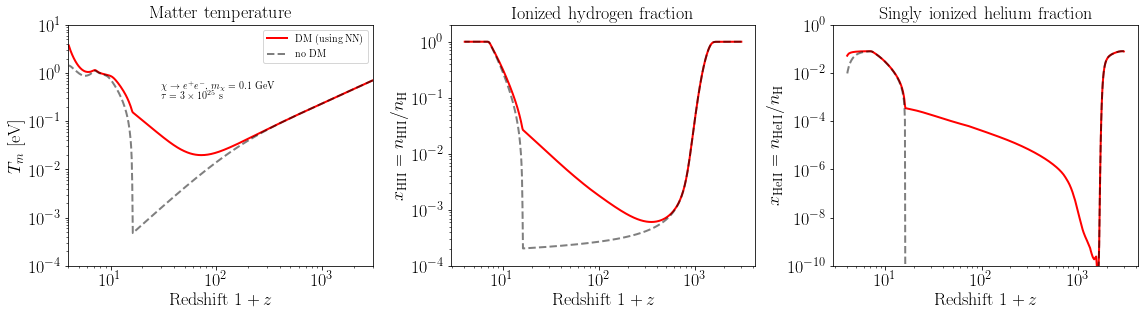

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16,4.5))

x = soln['rs']
y = soln['Tm']
ydflt = soln_baseline[:,0]
axs[0].plot(x, y    , 'r'  , lw=2, alpha=1.0, label='DM (using NN)')
axs[0].plot(x, ydflt, 'k--', lw=2, alpha=0.5, label='no DM')
axs[0].set(xscale='log', xlim=(4,3000), yscale='log', ylim=(1e-4,10))
axs[0].set(title='Matter temperature', xlabel=r'Redshift $1+z$', ylabel=r'$T_m$ [eV]')
textstr =  '$\chi \\to e^+e^-$, $m_\chi = 0.1$~GeV\n'
textstr += '$\\tau = 3 \\times 10^{25}$ s'
axs[0].text(30, 0.3, textstr)
axs[0].legend()

y = soln['x'][:,0]
ydflt = soln_baseline[:,1]
axs[1].plot(x, y    , 'r'  , lw=2, alpha=1.0, label='DM')
axs[1].plot(x, ydflt, 'k--', lw=2, alpha=0.5, label='no DM')
axs[1].set(xscale='log', xlim=(None, None), yscale='log', ylim=(1e-4, 2))
axs[1].set(title='Ionized hydrogen fraction', xlabel=r'Redshift $1+z$', ylabel=r'$x_\mathrm{HII}=n_\mathrm{HII}/n_\mathrm{H}$')

y = soln['x'][:,1]
ydflt = soln_baseline[:,2]
axs[2].plot(x, y    , 'r'  , lw=2, alpha=1.0, label='DM')
axs[2].plot(x, ydflt, 'k--', lw=2, alpha=0.5, label='no DM')
axs[2].set(xscale='log', yscale='log', ylim=(1e-10, 1))
axs[2].set(title='Singly ionized helium fraction', xlabel=r'Redshift $1+z$', ylabel=r'$x_\mathrm{HeII}=n_\mathrm{HeII}/n_\mathrm{H}$')

plt.tight_layout()
plt.show()

## 3.2 Plot low energy photon spectral distortion
(not contribution from low energy electrons and atomic transitions)

In [26]:
specs = soln['lowengphot']
summed_spec = specs[0]*0
for i in range(len(soln['rs'])):
    spec = specs[i]*1
    spec.redshift(1)
    summed_spec += spec

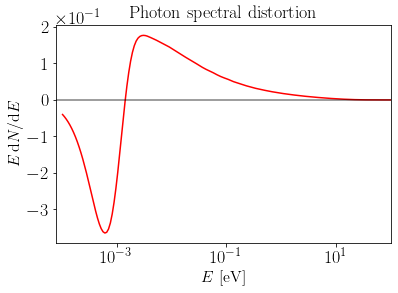

In [33]:
fig, ax = plt.subplots(1, 1)
ax.plot(summed_spec.eng, summed_spec.N, color='r', label='DM (using NN)')
ax.axhline(y=0, color='k', alpha=0.5)
ax.set(xscale='log', xlim=(8e-5,1e2))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title(r'Photon spectral distortion', fontsize=18)
ax.set_xlabel(r'$E$ [eV]', fontsize=16)
ax.set_ylabel(r'$E\,\mathrm{d}N/\mathrm{d}E$', fontsize=16)
plt.show()